# Практическая работа №3 (Изучение работы методов контроля температуры в молекулярной динамике)

In [1]:
%%bash
apt-get update
apt-get install -y gromacs


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,086 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [2]:
!gmx --version

                 :-) GROMACS - gmx, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

In [3]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 55.4 MB/s eta 0:00:00


In [5]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from IPython.display import Image,display
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import subprocess

In [22]:
!curl -O "http://kodomo.fbb.msu.ru/FBB/year_08/term6/etane.gro"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   344  100   344    0     0    511      0 --:--:-- --:--:-- --:--:--   511


In [8]:
%%bash
cat atomtypes.atp

; OPLS atom types and masses.
; Atom types are named opls_X, where X is the OPLS number.
; The opls_ prefix is to avoid users confusing atom types
; (always prefixed) with atom numbers in molecules (never prefixed).
;
; Types 1-134 are from the united-atom OPLS, which can be
; useful for solvents and/or CH2 optimizations (e.g. in lipids).
; Explicit all-atom parameters start with opls_135.
; Note: For UA amide parameters -
; NMA - types 1,2,3,4,7,39
; Formamide 131,2,12,13
; DMF       131,2,3,132
; Acetamide 1,2,7,12,13
;
; Types 1-65 are united-atom parameters for proteins, 
; see JACS 110, 1657 (1988).
;
 opls_001   12.01100  ;
 opls_002   15.99940  ; 
 opls_003   14.00670  ;  
 opls_004    1.00800  ; 
 opls_005   14.02700  ;
 opls_006   13.01900  ;
 opls_007   15.03500  ;
 opls_008   13.01900  ;
 opls_009   14.02700  ;
 opls_010   15.03500  ;
 opls_011   12.01100  ;
 opls_012   14.00670  ; 
 opls_013    1.00800  ; 
 opls_014   13.01900  ;
 opls_015   14.02700  ;
 opls_016   14.02700

In [9]:
%%bash
cat forcefield.itp

#define _FF_OPLS
#define _FF_OPLSAA

; This force field uses a format that requires Gromacs 3.1.4 or later.
;
; References for the OPLS-AA force field: 
;
; W. L. Jorgensen, D. S. Maxwell, and J. Tirado-Rives,
; J. Am. Chem. Soc. 118, 11225-11236 (1996).
; W. L. Jorgensen and N. A. McDonald, Theochem 424, 145-155 (1998).
; W. L. Jorgensen and N. A. McDonald, J. Phys. Chem. B 102, 8049-8059 (1998).
; R. C. Rizzo and W. L. Jorgensen, J. Am. Chem. Soc. 121, 4827-4836 (1999).
; M. L. Price, D. Ostrovsky, and W. L. Jorgensen, J. Comp. Chem. (2001).
; E. K. Watkins and W. L. Jorgensen, J. Phys. Chem. A 105, 4118-4125 (2001).
; G. A. Kaminski, R.A. Friesner, J.Tirado-Rives and W.L. Jorgensen, J. Phys. Chem. B 105, 6474 (2001).
;

[ defaults ]
; nbfunc	comb-rule	gen-pairs	fudgeLJ	fudgeQQ
1		3		yes		0.5	0.5

#include "ffnonbonded.itp"
#include "ffbonded.itp"


In [10]:
%%bash
cat ffbonded.itp

; Some esoteric OPLS atomtypes are not freely available (or depreciated).
; Interaction types involving these have been commented out.
  
[ bondtypes ]
; i    j  func       b0          kb
  OW    HW      1    0.09572   502080.0   ; For TIP4F Water - wlj 1/98  
  OW    LP      1    0.01750   753120.0   ;          -idem-
  C*    HC      1    0.10800   284512.0   ; 
  C     C3      1    0.15220   265265.6   ; END
  C_2   C3      1    0.15220   265265.6   ; END
  C_3   C3      1    0.15220   265265.6   ; END
  C     CA      1    0.14900   334720.0   ; wlj 8/97
  C_2   CA      1    0.14900   334720.0   ; wlj 8/97
  C_3   CA      1    0.14900   334720.0   ; wlj 8/97
  C     CB      1    0.14190   374049.6   ; GUA
  C_2   CB      1    0.14190   374049.6   ; GUA
  C_3   CB      1    0.14190   374049.6   ; GUA
  C     CM      1    0.14440   343088.0   ; THY
  C_2   CM      1    0.14440   343088.0   ; THY
  C_3   CM      1    0.14440   343088.0   ; THY
  C     CS      1    0.14900   334720.0   ;

Видим, что для dihedraltypes значение 3

C помощью библиотеки RDKit можно автоматически извлечь связи, углы и торсионные углы для молекулы этана, чтобы затем использовать их при создании топологии

In [11]:
# создадим этан
mol=Chem.MolFromSmiles('CC')
AllChem.Compute2DCoords(mol)
m3d=Chem.AddHs(mol)
Chem.AllChem.EmbedMolecule(m3d)
AllChem.MMFFOptimizeMolecule(m3d,maxIters=500,nonBondedThresh=200 )

0

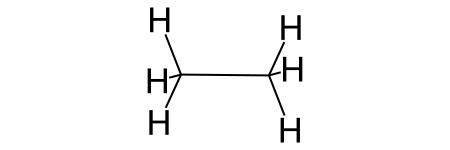

In [12]:
m3d

In [13]:
# придумаем циклы
# связи
bonds = m3d.GetBonds()
for i,b in enumerate(bonds):
  print (b.GetBeginAtomIdx()+1 , b.GetEndAtomIdx()+1, '1')

1 2 1
1 3 1
1 4 1
1 5 1
2 6 1
2 7 1
2 8 1


GetBeginAtomIdx() и GetEndAtomIdx() — индексы атомов, связанных этой связью.
Выводит все пары атомов, которые образуют ковалентные связи. Тут первая связь — между двумя углеродами, остальные — C–H.

In [14]:
# углы
for b1 in m3d.GetBonds():
    for b2 in m3d.GetBonds():
        if b1.GetBeginAtomIdx() == b2.GetBeginAtomIdx() and b1.GetIdx() != b2.GetIdx():
            print (b1.GetEndAtomIdx()+1,b1.GetBeginAtomIdx()+1, b2.GetEndAtomIdx()+1, '1')

2 1 3 1
2 1 4 1
2 1 5 1
3 1 2 1
3 1 4 1
3 1 5 1
4 1 2 1
4 1 3 1
4 1 5 1
5 1 2 1
5 1 3 1
5 1 4 1
6 2 7 1
6 2 8 1
7 2 6 1
7 2 8 1
8 2 6 1
8 2 7 1


Ищет пары связей, которые выходят из одного и того же центрального атома, то есть формируют угол вида (атом1 — центральный — атом2).
Результат — все возможные тройки атомов, образующих углы (например, H–C–H, H–C–C).

In [15]:
## торсионные углы
for b1 in m3d.GetBonds():
    for b2 in m3d.GetBonds():
        for b3 in m3d.GetBonds():
            if b1.GetBeginAtomIdx() == b2.GetBeginAtomIdx() and b1.GetIdx() != b2.GetIdx() and b2.GetEndAtomIdx()==b3.GetBeginAtomIdx() and b3.GetIdx() != b2.GetIdx():
                print (b1.GetEndAtomIdx()+1, b1.GetBeginAtomIdx()+1, b2.GetEndAtomIdx()+1, b3.GetEndAtomIdx()+1, '3')

3 1 2 6 3
3 1 2 7 3
3 1 2 8 3
4 1 2 6 3
4 1 2 7 3
4 1 2 8 3
5 1 2 6 3
5 1 2 7 3
5 1 2 8 3


Этот цикл ищет цепочки из трёх связей подряд, то есть последовательности из четырёх атомов (i–j–k–l).
Они определяют торсионные вращения, как H–C–C–H.

Теперь из полученных данных составила et.top для этана

In [20]:
%%bash
cat et.top

  #include "forcefield.itp"

  [ moleculetype ]
  ; Name            nrexcl
  et            3

  [ atoms ]
  ;   nr  type        resnr residue  atom   cgnr     charge       mass
      1   opls_135      1    ETH      C1      1    -0.174      12.01100
      2   opls_135      1    ETH      C2      2    -0.174      12.01100
      3   opls_140      1    ETH      H1      3     0.0058     1.00800
      4   opls_140      1    ETH      H2      4     0.0058     1.00800
      5   opls_140      1    ETH      H3      5     0.0058     1.00800
      6   opls_140      1    ETH      H4      6     0.0058     1.00800
      7   opls_140      1    ETH      H5      7     0.0058     1.00800
      8   opls_140      1    ETH      H6      8     0.0058     1.00800

  [ bonds ]
  ;  ai   aj funct  b0       kb
     1    2   1     0.15220  265265.6
     1    3   1     0.10800  284512.0
     1    4   1     0.10800  284512.0
     1    5   1     0.10800  284512.0
     2    6   1     0.10800  284512.0
     2    7   1   

In [17]:
%%bash
wget http://kodomo.fbb.msu.ru/FBB/year_08/term6/be.mdp
wget http://kodomo.fbb.msu.ru/FBB/year_08/term6/vr.mdp
wget http://kodomo.fbb.msu.ru/FBB/year_08/term6/nh.mdp
wget http://kodomo.fbb.msu.ru/FBB/year_08/term6/an.mdp
wget http://kodomo.fbb.msu.ru/FBB/year_08/term6/sd.mdp

--2025-10-22 07:03:20--  http://kodomo.fbb.msu.ru/FBB/year_08/term6/be.mdp
Resolving kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)... 93.180.63.127
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://kodomo.fbb.msu.ru/FBB/year_08/term6/be.mdp [following]
--2025-10-22 07:03:20--  https://kodomo.fbb.msu.ru/FBB/year_08/term6/be.mdp
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1354 (1.3K)
Saving to: ‘be.mdp’

     0K .                                                     100%  298M=0s

2025-10-22 07:03:21 (298 MB/s) - ‘be.mdp’ saved [1354/1354]

--2025-10-22 07:03:21--  http://kodomo.fbb.msu.ru/FBB/year_08/term6/vr.mdp
Resolving kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)... 93.180.63.127
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:80... connected.
HTTP request sent, awaiting re

In [23]:
for filename in ['be', 'vr', 'nh', 'an', 'sd']:
    print(f"Running grompp for {filename}...")
    !gmx grompp -f {filename}.mdp -c etane.gro -p et.top -o et_{filename}.tpr

Running grompp for be...
              :-) GROMACS - gmx grompp, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Piet

In [24]:
for filename in ['be','vr','nh','an','sd']:
    !gmx mdrun -deffnm et_{filename} -v -nt 1 -o et_{filename}.trr

              :-) GROMACS - gmx mdrun, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

In [25]:
for filename in ['be','vr','nh','an','sd']:
    !echo 0 | gmx trjconv -f et_{filename}.trr -s et_{filename}.tpr -o et_{filename}.pdb

             :-) GROMACS - gmx trjconv, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [36]:
for filename in ['be','vr','nh','an','sd']:
    !gmx energy -f et_{filename}.edr -o et_{filename}_pot_en.xvg -xvg none


              :-) GROMACS - gmx energy, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

Andersen temperature control not supported for integrator md. Так что его не рассматриваем

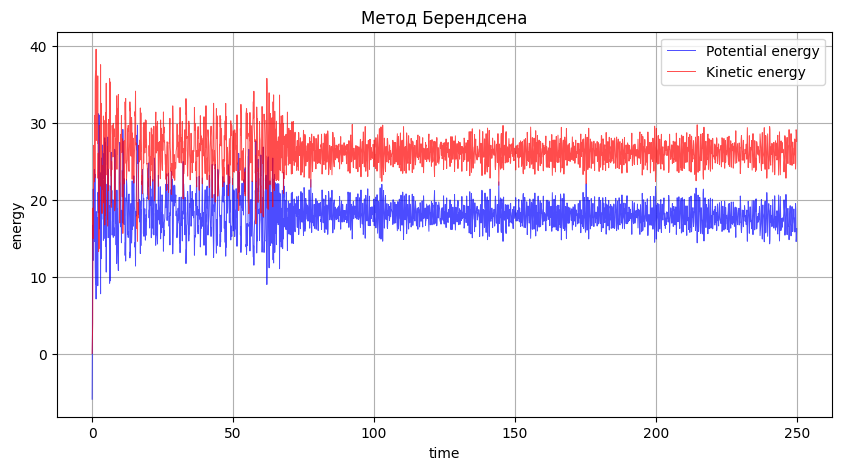

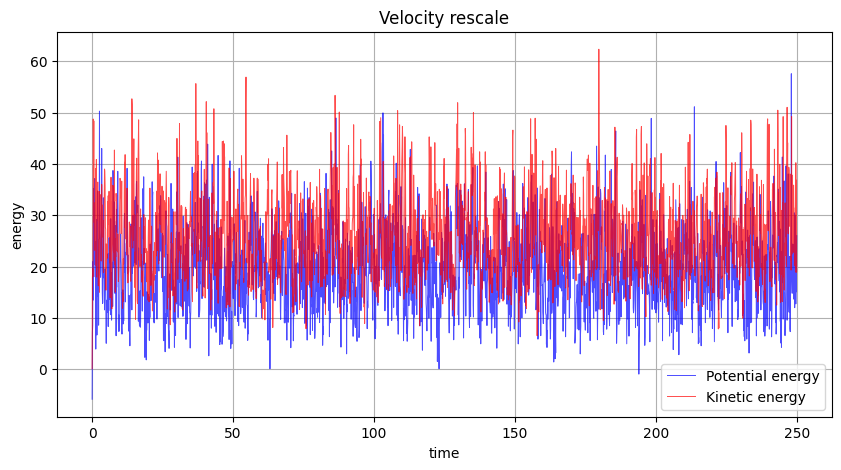

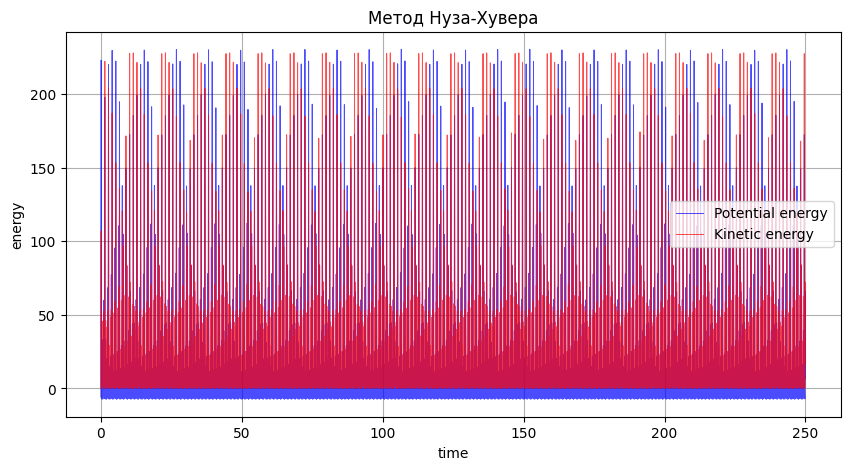

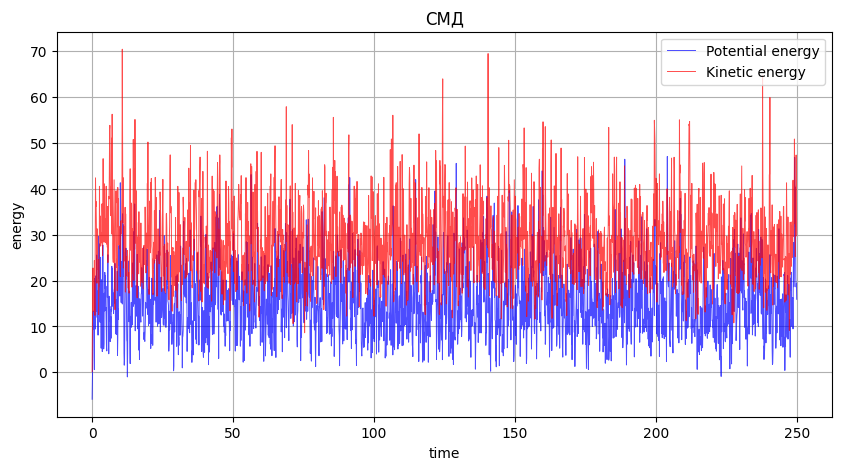

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
titles = {
'be': 'Метод Берендсена',
'nh': 'Метод Нуза-Хувера',
'vr': 'Velocity rescale',
'sd': 'СМД'}

for i in ["be","vr","nh","sd"]:
    plt.figure(figsize=(10, 5))
    a_pot = np.loadtxt('et_%s_pot_en.xvg' % i)
    t_pot = a_pot[:,0]
    y_pot = a_pot[:,1]
    a_kin = np.loadtxt('et_%s_kin_en.xvg' % i)
    t_kin = a_kin[:,0]
    y_kin = a_kin[:,1]
    plt.grid(True)
    plt.plot(t_pot, y_pot, linewidth=0.7, alpha=0.7, color='blue', label='Potential energy')
    plt.plot(t_kin, y_kin, linewidth=0.7, alpha=0.7, color='red', label='Kinetic energy')
    plt.legend()
    plt.title(titles[i])
    plt.xlabel("time")
    plt.ylabel("energy")
    plt.show()

In [ ]:
for filename in ['be','vr','nh','an','sd']:
    !gmx energy -f et_{filename}.edr -o et_{filename}_pot_en.xvg -xvg none
    !gmx energy -f et_{filename}.edr -o et_{filename}_kin_en.xvg -xvg none

              :-) GROMACS - gmx energy, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [46]:
for filename in ['be','vr','nh','sd']:
    !echo 0 | gmx distance -f et_{filename}.trr -s et_{filename}.tpr -oh bond_{filename}.xvg -n b.ndx -xvg none

             :-) GROMACS - gmx distance, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff           

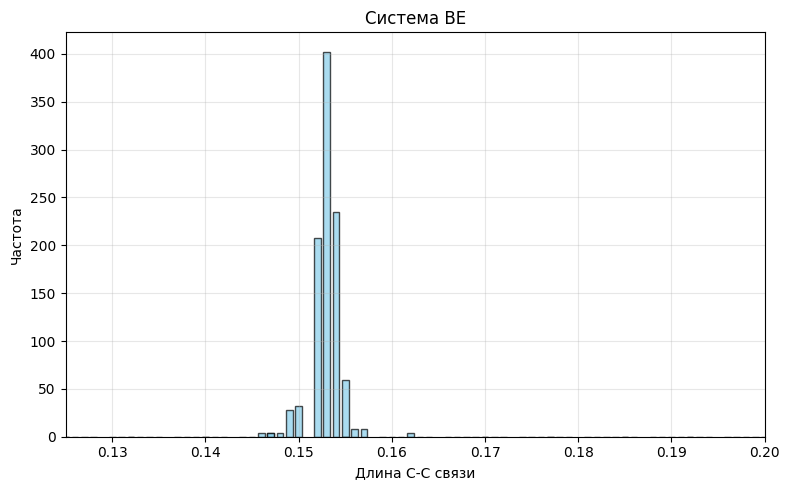

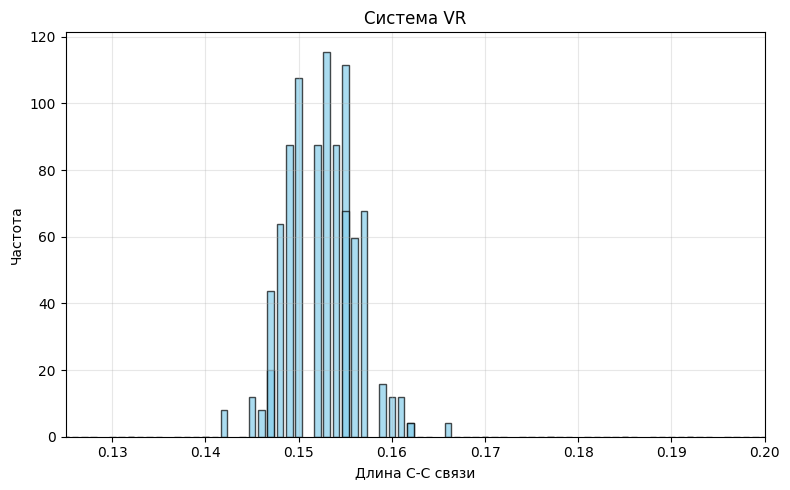

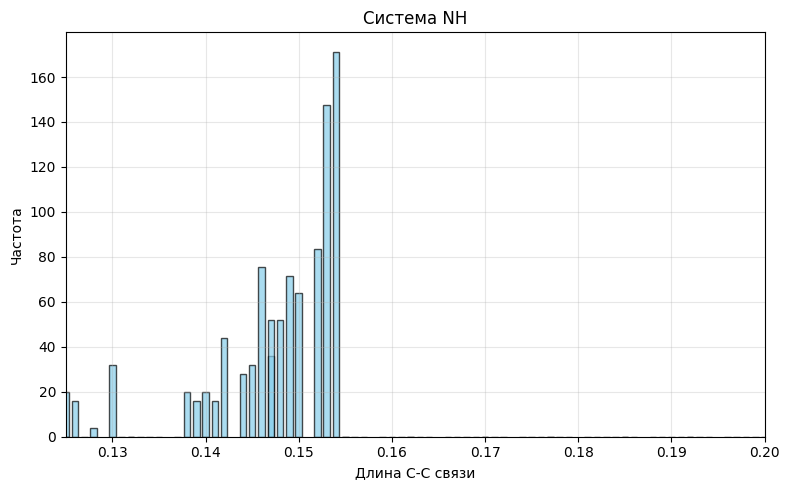

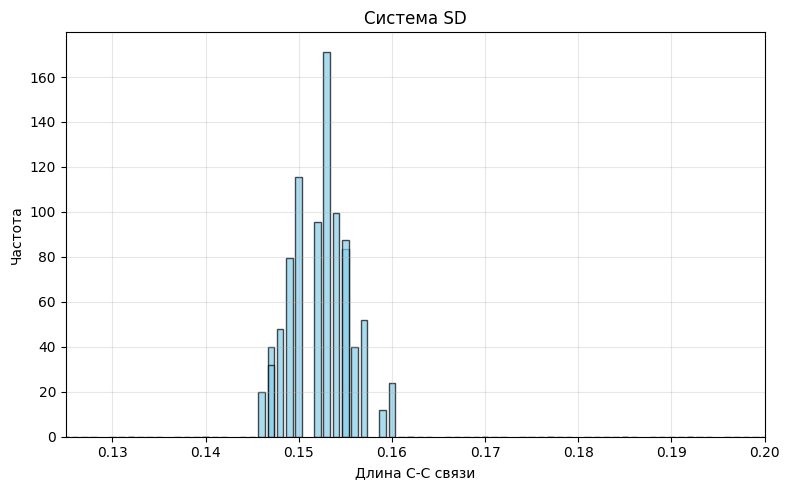

In [48]:
for i in ["be","vr","nh","sd"]:
    a = np.loadtxt("bond_%s.xvg" % i)
    x = a[:,0]
    y = a[:,1]

    plt.figure(figsize=(8, 5))
    plt.bar(x, y, width=0.0007, color='skyblue', edgecolor='black', alpha=0.7)
    plt.grid(True, alpha=0.3)
    plt.title(f"Система {i.upper()}")
    plt.xlabel("Длина С-С связи")
    plt.ylabel("Частота")
    plt.xlim(0.125, 0.2)
    plt.tight_layout()
    plt.show()